In [120]:
#library required
import psycopg2

from sqlalchemy import create_engine
from sqlalchemy import text
import os
import time 
from datetime import datetime
import io 
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np




In [121]:
#Loading the data from s3 csv

# Define the file path
file_path = r"C:\Users\Poovesh Kumar M\Downloads\Planning\\1_Data\demand_planning_MPBH_22_08_2024.csv"

# Read the CSV file into a DataFrame
df_base = pd.read_csv(file_path)

# Display the DataFrame
print(df_base)

C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25160\2056393971.py:7: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_base = pd.read_csv(file_path)


                 brand sales_channel  sales_date sale_month_year        asin  \
0        majestic pure    Amazon.com  2024-07-28         07-2024  B06XCCVDH7   
1        majestic pure    Amazon.com  2024-07-24         07-2024  B06XCCVDH7   
2        majestic pure    Amazon.com  2024-07-20         07-2024  B06XCCVDH7   
3        majestic pure    Amazon.com  2024-07-16         07-2024  B06XCCVDH7   
4        majestic pure    Amazon.com  2024-07-12         07-2024  B06XCCVDH7   
...                ...           ...         ...             ...         ...   
312473   majestic pure    Amazon.com  2024-07-26         07-2024  B08YS7DPH3   
312474   majestic pure    Amazon.com  2024-07-27         07-2024  B09JL8V6RB   
312475  botanic hearth    Amazon.com  2024-07-29         07-2024  B08SQFQC3X   
312476   majestic pure    Amazon.com  2024-07-30         07-2024  B08YS7DPH3   
312477   majestic pure    Amazon.com  2024-07-31         07-2024  B09JL8V6RB   

       earliest_date_brand_channel earl

In [4]:
# 2. Filter (df2): brand x channel level into individual dataframes
df_bh_us = df_base[(df_base['brand'] == 'botanic hearth') & (df_base['sales_channel'] == 'Amazon.com')]
df_bh_ca = df_base[(df_base['brand'] == 'botanic hearth') & (df_base['sales_channel'] == 'Amazon.ca')]
df_mp_us = df_base[(df_base['brand'] == 'majestic pure') & (df_base['sales_channel'] == 'Amazon.com')]
df_mp_ca = df_base[(df_base['brand'] == 'majestic pure') & (df_base['sales_channel'] == 'Amazon.ca')]



In [5]:
# Save the brand x sales channel DataFrame to an csv file
date_str = '22_08_24'

df_bh_us.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_bh_us_' + date_str + '.csv', index=False)
df_bh_ca.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_bh_ca_' + date_str + '.csv', index=False)
df_mp_us.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_mp_us_' + date_str + '.csv', index=False)
df_mp_ca.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_mp_ca_' + date_str + '.csv', index=False)


In [122]:
# Read the CSV file into a DataFrame
df_bh_us = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_bh_us_22_08_24.csv")
df_bh_ca = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_bh_ca_22_08_24.csv")
df_mp_us = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_mp_us_22_08_24.csv")
df_mp_ca = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_mp_ca_22_08_24.csv")


C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25160\3105605346.py:2: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bh_us = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_bh_us_22_08_24.csv")
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25160\3105605346.py:4: DtypeWarning: Columns (13,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mp_us = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_mp_us_22_08_24.csv")


In [123]:
# creating input df
df_bs1 = df_mp_us #chnage to load the df 


# Display the first few rows of the filtered DataFrame
print(df_bs1.head())


# Step 2: Create a list of distinct 'brand' and 'sales_channel' combinations
brands_channel_list = [f"{brand.replace('.', '_')}_{channel.replace('.', '_')}" 
                       for brand, channel in df_bs1[['brand', 'sales_channel']].drop_duplicates().values]

# Step 3: Convert the list to a single string, separated by commas
brands_channel_str = ', '.join(brands_channel_list)

# Display the combined string
print(brands_channel_str)

           brand sales_channel  sales_date sale_month_year        asin  \
0  majestic pure    Amazon.com  2024-07-28         07-2024  B06XCCVDH7   
1  majestic pure    Amazon.com  2024-07-24         07-2024  B06XCCVDH7   
2  majestic pure    Amazon.com  2024-07-20         07-2024  B06XCCVDH7   
3  majestic pure    Amazon.com  2024-07-16         07-2024  B06XCCVDH7   
4  majestic pure    Amazon.com  2024-07-12         07-2024  B06XCCVDH7   

  earliest_date_brand_channel earliest_date currency       asp  gmv_units  \
0                  2022-10-01    2024-07-28      USD  14.99000          7   
1                  2022-10-01    2024-07-24      USD  14.99000          6   
2                  2022-10-01    2024-07-20      USD  14.99000          2   
3                  2022-10-01    2024-07-16      USD  15.15125          8   
4                  2022-10-01    2024-07-12      USD  14.99000          6   

   ...  ad_spend  inventory_available      category sub_category  \
0  ...  3.118138        

In [124]:
# Display DataFrame shape
print("Shape of the DataFrame:")
print(df_bs1.shape)
print("\n")

# Display the first 10 rows
print("First 10 rows of the DataFrame:")
print(df_bs1.head(10))
print("\n")

# Display data types of each column
print("Data types of each column:")
print(df_bs1.dtypes)
print("\n")

# Display information about the DataFrame
print("DataFrame information:")
df_bs1.info()
print("\n")

# Display summary statistics
print("Summary statistics of the DataFrame:")
print(df_bs1.describe())
print("\n")

# Display the number of missing values in each column
print("Missing values in each column:")
print(df_bs1.isnull().sum())
print("\n")

# Display the number of unique values in each column
print("Number of unique values in each column:")
print(df_bs1.nunique())


Shape of the DataFrame:
(196946, 21)


First 10 rows of the DataFrame:
           brand sales_channel  sales_date sale_month_year        asin  \
0  majestic pure    Amazon.com  2024-07-28         07-2024  B06XCCVDH7   
1  majestic pure    Amazon.com  2024-07-24         07-2024  B06XCCVDH7   
2  majestic pure    Amazon.com  2024-07-20         07-2024  B06XCCVDH7   
3  majestic pure    Amazon.com  2024-07-16         07-2024  B06XCCVDH7   
4  majestic pure    Amazon.com  2024-07-12         07-2024  B06XCCVDH7   
5  majestic pure    Amazon.com  2024-07-08         07-2024  B06XCCVDH7   
6  majestic pure    Amazon.com  2024-07-04         07-2024  B06XCCVDH7   
7  majestic pure    Amazon.com  2024-06-30         06-2024  B06XCCVDH7   
8  majestic pure    Amazon.com  2024-06-26         06-2024  B06XCCVDH7   
9  majestic pure    Amazon.com  2024-06-22         06-2024  B06XCCVDH7   

  earliest_date_brand_channel earliest_date currency       asp  gmv_units  \
0                  2022-10-01    2024

In [125]:
# Removing Outlier
#Step 1: No inventory
# Filter rows where 'inventory_available' is greater than 0

# df_bs2 = df_bs1[df_bs1['inventory_available'] > 0]
df_bs2 = df_bs1
# Display the first few rows of the filtered DataFrame
print(df_bs2.head())




           brand sales_channel  sales_date sale_month_year        asin  \
0  majestic pure    Amazon.com  2024-07-28         07-2024  B06XCCVDH7   
1  majestic pure    Amazon.com  2024-07-24         07-2024  B06XCCVDH7   
2  majestic pure    Amazon.com  2024-07-20         07-2024  B06XCCVDH7   
3  majestic pure    Amazon.com  2024-07-16         07-2024  B06XCCVDH7   
4  majestic pure    Amazon.com  2024-07-12         07-2024  B06XCCVDH7   

  earliest_date_brand_channel earliest_date currency       asp  gmv_units  \
0                  2022-10-01    2024-07-28      USD  14.99000          7   
1                  2022-10-01    2024-07-24      USD  14.99000          6   
2                  2022-10-01    2024-07-20      USD  14.99000          2   
3                  2022-10-01    2024-07-16      USD  15.15125          8   
4                  2022-10-01    2024-07-12      USD  14.99000          6   

   ...  ad_spend  inventory_available      category sub_category  \
0  ...  3.118138        

In [126]:
# Display DataFrame shape
print("Shape of the DataFrame:")
print(df_bs2.shape)
print("\n")

# Display the first 10 rows
print("First 10 rows of the DataFrame:")
print(df_bs2.head(10))
print("\n")

# Display data types of each column
print("Data types of each column:")
print(df_bs2.dtypes)
print("\n")

# Display information about the DataFrame
print("DataFrame information:")
df_bs2.info()
print("\n")

# Display summary statistics
print("Summary statistics of the DataFrame:")
print(df_bs2.describe())
print("\n")

# Display the number of missing values in each column
print("Missing values in each column:")
print(df_bs2.isnull().sum())
print("\n")

# Display the number of unique values in each column
print("Number of unique values in each column:")
print(df_bs2.nunique())


Shape of the DataFrame:
(196946, 21)


First 10 rows of the DataFrame:
           brand sales_channel  sales_date sale_month_year        asin  \
0  majestic pure    Amazon.com  2024-07-28         07-2024  B06XCCVDH7   
1  majestic pure    Amazon.com  2024-07-24         07-2024  B06XCCVDH7   
2  majestic pure    Amazon.com  2024-07-20         07-2024  B06XCCVDH7   
3  majestic pure    Amazon.com  2024-07-16         07-2024  B06XCCVDH7   
4  majestic pure    Amazon.com  2024-07-12         07-2024  B06XCCVDH7   
5  majestic pure    Amazon.com  2024-07-08         07-2024  B06XCCVDH7   
6  majestic pure    Amazon.com  2024-07-04         07-2024  B06XCCVDH7   
7  majestic pure    Amazon.com  2024-06-30         06-2024  B06XCCVDH7   
8  majestic pure    Amazon.com  2024-06-26         06-2024  B06XCCVDH7   
9  majestic pure    Amazon.com  2024-06-22         06-2024  B06XCCVDH7   

  earliest_date_brand_channel earliest_date currency       asp  gmv_units  \
0                  2022-10-01    2024

In [127]:
#creating ASINx VB for mapping purpose
# Remove rows where 'asin' is null
df_asin_vb = df_bs2.dropna(subset=['asin'])

# Select distinct 'asin' and 'velocity_bucket' combinations
df_asin_vb = df_asin_vb[['asin', 'velocity_bucket']].drop_duplicates()

# Display the resulting DataFrame
print("Distinct asin x velocity_bucket:")
print(df_asin_vb.head())

Distinct asin x velocity_bucket:
            asin velocity_bucket
0     B06XCCVDH7              SM
167   B079ZN8SC9               F
335   B07G8M3DTX               F
791   B07NS43346               F
1067  B07PQWXW5B               M


In [129]:
# Check for asin Mapped to Multiple velocity_bucket Values
# Group by 'asin' and count the number of unique 'velocity_bucket' values
asin_multiple_vb = df_asin_vb.groupby('asin')['velocity_bucket'].nunique()

# Filter to find asins that are mapped to more than one velocity_bucket
asin_with_multiple_vb = asin_multiple_vb[asin_multiple_vb > 1]

print("ASINs mapped to multiple velocity buckets:")
print(asin_with_multiple_vb)

# # Group by 'velocity_bucket' and count the number of unique 'asin' values
# vb_multiple_asin = df_asin_vb.groupby('velocity_bucket')['asin'].nunique()

# # Filter to find velocity_buckets that are mapped to more than one asin
# vb_with_multiple_asin = vb_multiple_asin[vb_multiple_asin > 1]

# print("Velocity buckets mapped to multiple ASINs:")
# print(vb_with_multiple_asin)

ASINs mapped to multiple velocity buckets:
Series([], Name: velocity_bucket, dtype: int64)


# Display DataFrame shape
print("Shape of the DataFrame:")
print(df_bs3_no_outliers.shape)
print("\n")

# Display the first 10 rows
print("First 10 rows of the DataFrame:")
print(df_bs3_no_outliers.head(10))
print("\n")

# Display data types of each column
print("Data types of each column:")
print(df_bs3_no_outliers.dtypes)
print("\n")

# Display information about the DataFrame
print("DataFrame information:")
df_bs3_no_outliers.info()
print("\n")

# Display summary statistics
print("Summary statistics of the DataFrame:")
print(df_bs3_no_outliers.describe())
print("\n")

# Display the number of missing values in each column
print("Missing values in each column:")
print(df_bs3_no_outliers.isnull().sum())
print("\n")

# Display the number of unique values in each column
print("Number of unique values in each column:")
print(df_bs3_no_outliers.nunique())


#Visualisation of sample asin's - Radom

# Select some sample 'asin' values to plot
sample_asins = df_bs3['asin'].sample(3, random_state=42).unique()

# Filter the original and outlier-removed DataFrames for the selected 'asin' values
df_sample_before = df_bs3[df_bs3['asin'].isin(sample_asins)]
df_sample_after = df_bs3_no_outliers[df_bs3_no_outliers['asin'].isin(sample_asins)]

# Set up the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot the data before outlier removal
sns.boxplot(x='asin', y='gmv_units', data=df_sample_before, ax=axes[0])
axes[0].set_title('Before Outlier Removal')

# Plot the data after outlier removal
sns.boxplot(x='asin', y='gmv_units', data=df_sample_after, ax=axes[1])
axes[1].set_title('After Outlier Removal')

# Display the plots
plt.tight_layout()
plt.show()


#Visualisation of sample asin's - Box plot user input 

# Define the list of 'asin' values to visualize (replace with your own list)
sample_asins = ['B07JD9FS28','B079ZN8SC9', 'B09S26ZF1N', 'B09PZSKJ5N']  # Replace these with actual ASINs

# Filter the original and outlier-removed DataFrames for the selected 'asin' values
df_sample_before = df_bs3[df_bs3['asin'].isin(sample_asins)]
df_sample_after = df_bs3_no_outliers[df_bs3_no_outliers['asin'].isin(sample_asins)]

# Set up the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot the data before outlier removal
sns.boxplot(x='asin', y='gmv_units', data=df_sample_before, ax=axes[0])
axes[0].set_title('Before Outlier Removal')

# Plot the data after outlier removal
sns.boxplot(x='asin', y='gmv_units', data=df_sample_after, ax=axes[1])
axes[1].set_title('After Outlier Removal')

# Display the plots
plt.tight_layout()
plt.show()


#Visualisation of sample asin's - line chart user input 
# Define the list of 'asin' values to visualize
sample_asins = ['B07JD9FS28', 'B079ZN8SC9', 'B09S26ZF1N', 'B09PZSKJ5N']  # Replace with actual ASINs

# Filter the original and outlier-removed DataFrames for the selected 'asin' values
df_sample_before = df_bs3[df_bs3['asin'].isin(sample_asins)]
df_sample_after = df_bs3_no_outliers[df_bs3_no_outliers['asin'].isin(sample_asins)]

# Convert 'sales_date' to datetime if it's not already
df_sample_before['sales_date'] = pd.to_datetime(df_sample_before['sales_date'])
df_sample_after['sales_date'] = pd.to_datetime(df_sample_after['sales_date'])

# Set up the figure and axes
fig, axes = plt.subplots(len(sample_asins), 2, figsize=(14, len(sample_asins) * 5), sharex=True, sharey=True)

# Plot the data before outlier removal
for i, asin in enumerate(sample_asins):
    ax_before = axes[i, 0]
    ax_after = axes[i, 1]
    
    data_before = df_sample_before[df_sample_before['asin'] == asin]
    data_after = df_sample_after[df_sample_after['asin'] == asin]

    sns.lineplot(x='sales_date', y='gmv_units', data=data_before, ax=ax_before, marker='o')
    sns.lineplot(x='sales_date', y='gmv_units', data=data_after, ax=ax_after, marker='o')

    ax_before.set_title(f'Before Outlier Removal: {asin}')
    ax_after.set_title(f'After Outlier Removal: {asin}')

# Adjust layout
plt.tight_layout()
plt.show()


In [45]:
# Rolling up data - month level

# Convert 'sales_date' to datetime format if it isn't already
df_bs3['sales_date'] = pd.to_datetime(df_bs3['sales_date'])

# Extract year and month, set the day to '01', and then convert to date
df_bs3['year_month'] = df_bs3['sales_date'].dt.to_period('M').dt.to_timestamp().dt.date

# Group by 'asin' and 'year_month' to summarize 'gmv_units'
df_monthly = df_bs3.groupby(['asin', 'year_month'], as_index=False)['gmv_units'].sum()

print("Monthly summarized data:")
print(df_monthly.head())

# Pivot the monthly data to have 'asin' in rows and 'year_month' in columns
df_pivot_month = df_monthly.pivot(index='asin', columns='year_month', values='gmv_units').fillna(0)

# Reset index to make 'asin' a column
df_pivot_month.reset_index(inplace=True)

print("Pivoted data:")
print(df_pivot_month.head())




Monthly summarized data:
         asin  year_month  gmv_units
0  B00PMR3QF2  2023-03-01        641
1  B00PMR3QF2  2023-04-01      10903
2  B00PMR3QF2  2023-05-01       9013
3  B00PMR3QF2  2023-06-01      11026
4  B00PMR3QF2  2023-07-01      10390
Pivoted data:
year_month        asin  2023-03-01  2023-04-01  2023-05-01  2023-06-01  \
0           B00PMR3QF2       641.0     10903.0      9013.0     11026.0   
1           B00PV15BPW       421.0      7118.0      6070.0      9422.0   
2           B00Q96XGUU         9.0        67.0        92.0       103.0   
3           B00QR6SS6O       198.0      3642.0      3205.0      4063.0   
4           B00QR7FTLU        33.0       285.0       215.0       272.0   

year_month  2023-07-01  2023-08-01  2023-09-01  2023-10-01  2023-11-01  \
0              10390.0     10382.0      8682.0      8787.0     10559.0   
1              10013.0     10309.0      9744.0     10849.0      8005.0   
2                408.0       125.0       148.0       116.0        50.0  

C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25160\2387614395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs3['sales_date'] = pd.to_datetime(df_bs3['sales_date'])
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25160\2387614395.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs3['year_month'] = df_bs3['sales_date'].dt.to_period('M').dt.to_timestamp().dt.date


In [15]:
# Removing Outlier (IQR)
# Step 2: 

# Select the required columns from the original DataFrame
df_bs3 = df_bs2[['sales_date', 'asin', 'gmv_units']]

# Define a function to remove outliers for each 'asin'
def remove_outliers(group):
    Q1 = group['gmv_units'].quantile(0.25)
    Q3 = group['gmv_units'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['gmv_units'] >= lower_bound) & (group['gmv_units'] <= upper_bound)]

# Apply the function to remove outliers for each 'asin'
df_bs3_no_outliers = df_bs3.groupby('asin').apply(remove_outliers).reset_index(drop=True)

# Display the DataFrame after removing outliers
print("DataFrame after removing outliers:")
print(df_bs3_no_outliers)


DataFrame after removing outliers:
       sales_date        asin  gmv_units
0      2024-07-31  B00PMR3QF2        241
1      2024-07-27  B00PMR3QF2        228
2      2024-07-23  B00PMR3QF2        219
3      2024-07-19  B00PMR3QF2        191
4      2024-07-15  B00PMR3QF2        225
...           ...         ...        ...
83257  2024-07-15  B0D8HVYNM8          0
83258  2024-07-29  B0D8HVYNM8          0
83259  2024-07-25  B0D8HVYNM8          0
83260  2024-07-21  B0D8HVYNM8          0
83261  2024-07-17  B0D8HVYNM8          0

[83262 rows x 3 columns]


In [46]:
#Collecting Samples of ASINs vs Velocity Buckets vs monthly sales

# Assuming df_bs2 has 'asin' and 'velocity_bucket' columns
df_merged_month = df_asin_vb[['asin', 'velocity_bucket']].merge(df_pivot_month, on='asin', how='right')

# Reorder columns to have 'velocity_bucket', 'asin', and then the month-year columns
columns_order = ['velocity_bucket', 'asin'] + list(df_merged_month.columns[2:])
df_month = df_merged_month[columns_order]

# Replace null values in 'velocity_bucket' with a placeholder 'NULL'
df_month['velocity_bucket'] = df_month['velocity_bucket'].fillna('NULL')

# Define the custom order for velocity_bucket, using 'NULL' as the placeholder
custom_order = ['SF', 'F', 'M', 'SM', 'NULL']

# Convert 'velocity_bucket' to a categorical type with the custom order
df_month['velocity_bucket'] = pd.Categorical(df_month['velocity_bucket'], categories=custom_order, ordered=True)

# Sort the DataFrame by the custom order
df_month_sorted = df_month.sort_values(by='velocity_bucket').reset_index(drop=True)

# print("Final DataFrame:")
print("Final DataFrame sorted by velocity_bucket:")
print(df_final_sorted.head())

df_month_sorted.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/VB_ASIN_sales_month_year_'+brands_channel_str+'.csv')

Final DataFrame sorted by velocity_bucket:
  velocity_bucket        asin  2023-03-01  2023-04-01  2023-05-01  2023-06-01  \
0              SF  B00PMR3QF2       641.0     10903.0      9013.0     11026.0   
1              SF  B00PV15BPW       421.0      7118.0      6070.0      9422.0   
2              SF  B01BKB3C98       244.0      3623.0      3202.0      6693.0   
3              SF  B00TSTZQEY       877.0     12371.0     11257.0     15074.0   
4              SF  B0C2Z44JLK         0.0         0.0         0.0       737.0   

   2023-07-01  2023-08-01  2023-09-01  2023-10-01  2023-11-01  2023-12-01  \
0     10390.0     10382.0      8682.0      8787.0     10559.0      9064.0   
1     10013.0     10309.0      9744.0     10849.0      8005.0      6186.0   
2      5293.0      4534.0      3506.0      3579.0      3456.0      2964.0   
3     14054.0     13346.0     10139.0     11879.0     13516.0     11435.0   
4      2016.0      4473.0      6354.0      2636.0      7318.0      7274.0   

   2024

PermissionError: [Errno 13] Permission denied: 'C:/Users/Poovesh Kumar M/Downloads/Planning/VB_ASIN_sales_month_year_majestic pure_Amazon_com.csv'

In [48]:
# Rolling up data - week level

# Convert 'sales_date' to datetime format if it isn't already
df_bs3['sales_date'] = pd.to_datetime(df_bs3['sales_date'])

# Extract the week and year, setting the week to start on Monday
df_bs3['year_week'] = df_bs3['sales_date'].dt.to_period('W-SUN').apply(lambda r: r.start_time.date())

# Group by 'asin' and 'year_week' to summarize 'gmv_units'
df_weekly = df_bs3.groupby(['asin', 'year_week'], as_index=False)['gmv_units'].sum()

print("Weekly summarized data:")
print(df_weekly.head())

# Pivot the monthly data to have 'asin' in rows and 'year_month' in columns
df_pivot_week = df_weekly.pivot(index='asin', columns='year_week', values='gmv_units').fillna(0)

# Reset index to make 'asin' a column
df_pivot_week.reset_index(inplace=True)

print("Pivoted data:")
print(df_pivot_week.head())

C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25160\1380257752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs3['sales_date'] = pd.to_datetime(df_bs3['sales_date'])


Weekly summarized data:
         asin   year_week  gmv_units
0  B00PMR3QF2  2023-03-27       1379
1  B00PMR3QF2  2023-04-03       2789
2  B00PMR3QF2  2023-04-10       2526
3  B00PMR3QF2  2023-04-17       3102
4  B00PMR3QF2  2023-04-24       1748
Pivoted data:
year_week        asin  2023-03-27  2023-04-03  2023-04-10  2023-04-17  \
0          B00PMR3QF2      1379.0      2789.0      2526.0      3102.0   
1          B00PV15BPW       862.0      1761.0      1932.0      1643.0   
2          B00Q96XGUU        18.0        10.0        18.0        15.0   
3          B00QR6SS6O       430.0       902.0       947.0       860.0   
4          B00QR7FTLU        49.0        80.0        82.0        45.0   

year_week  2023-04-24  2023-05-01  2023-05-08  2023-05-15  2023-05-22  ...  \
0              1748.0      2050.0      2001.0      1336.0      3005.0  ...   
1              1341.0      1669.0      1593.0      1118.0      1305.0  ...   
2                15.0        30.0        22.0        17.0        15

C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25160\1380257752.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs3['year_week'] = df_bs3['sales_date'].dt.to_period('W-SUN').apply(lambda r: r.start_time.date())


In [49]:
#Collecting Samples of ASINs vs Velocity Buckets vs weekly sales

# Assuming df_bs2 has 'asin' and 'velocity_bucket' columns
df_merged_week = df_asin_vb[['asin', 'velocity_bucket']].merge(df_pivot_week, on='asin', how='right')

# Reorder columns to have 'velocity_bucket', 'asin', and then the month-year columns
columns_order = ['velocity_bucket', 'asin'] + list(df_merged_week.columns[2:])
df_week = df_merged_week[columns_order]

# Replace null values in 'velocity_bucket' with a placeholder 'NULL'
df_week['velocity_bucket'] = df_week['velocity_bucket'].fillna('NULL')

# Define the custom order for velocity_bucket, using 'NULL' as the placeholder
custom_order = ['SF', 'F', 'M', 'SM', 'NULL']

# Convert 'velocity_bucket' to a categorical type with the custom order
df_week['velocity_bucket'] = pd.Categorical(df_week['velocity_bucket'], categories=custom_order, ordered=True)

# Sort the DataFrame by the custom order
df_week_sorted = df_week.sort_values(by='velocity_bucket').reset_index(drop=True)

# print("Final DataFrame:")
print("Final DataFrame sorted by velocity_bucket:")
print(df_week_sorted.head())

df_week_sorted.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/VB_ASIN_sales_week_year_'+brands_channel_str+'.csv')

Final DataFrame sorted by velocity_bucket:
  velocity_bucket        asin  2023-03-27  2023-04-03  2023-04-10  2023-04-17  \
0              SF  B00PMR3QF2      1379.0      2789.0      2526.0      3102.0   
1              SF  B00PV15BPW       862.0      1761.0      1932.0      1643.0   
2              SF  B01BKB3C98       488.0       803.0      1065.0       864.0   
3              SF  B00TSTZQEY      1736.0      2854.0      3229.0      2855.0   
4              SF  B0C2Z44JLK         0.0         0.0         0.0         0.0   

   2023-04-24  2023-05-01  2023-05-08  2023-05-15  ...  2024-05-27  \
0      1748.0      2050.0      2001.0      1336.0  ...      1232.0   
1      1341.0      1669.0      1593.0      1118.0  ...      1308.0   
2       647.0       344.0       542.0       789.0  ...      1063.0   
3      2574.0      2778.0      2567.0      2036.0  ...       351.0   
4         0.0         0.0         0.0         0.0  ...      2064.0   

   2024-06-03  2024-06-10  2024-06-17  2024-06-24

In [118]:
#Batches:

# print(df_monthly.dtypes)


# Manually specify the dates you're interested in
# Replace with the dates you need
selected_dates = ['2023-03-01','2023-04-01','2023-05-01','2023-06-01','2023-07-01','2023-08-01']  


# Convert the dates to datetime.date format if they are in string format
selected_dates = [pd.to_datetime(date).date() for date in selected_dates]

# Filter the df_monthly DataFrame to include only the selected dates
df_batch1 = df_monthly[df_monthly['year_month'].isin(selected_dates)]

# Display the resulting DataFrame
print("Filtered DataFrame with selected dates:")
print(df_batch1)



Filtered DataFrame with selected dates:
            asin  year_month  gmv_units
0     B00PMR3QF2  2023-03-01        641
1     B00PMR3QF2  2023-04-01      10903
2     B00PMR3QF2  2023-05-01       9013
3     B00PMR3QF2  2023-06-01      11026
4     B00PMR3QF2  2023-07-01      10390
...          ...         ...        ...
2931  B0C65CVJQG  2023-08-01        882
2954  B0C6XVFJPZ  2023-08-01        305
2977  B0C6Y478R5  2023-07-01        257
2978  B0C6Y478R5  2023-08-01       2240
2990  B0CBVD9G2B  2023-08-01          5

[1113 rows x 3 columns]


In [113]:
df_monthly 
# df_batch1

,asin,year_month,gmv_units
0,B00PMR3QF2,2023-03-01,641
1,B00PMR3QF2,2023-04-01,10903
2,B00PMR3QF2,2023-05-01,9013
3,B00PMR3QF2,2023-06-01,11026
4,B00PMR3QF2,2023-07-01,10390
...,...,...,...
3190,B0D7HX5FJF,2024-07-01,544
3191,B0D7HZ6883,2024-07-01,765
3192,B0D7HZR4XL,2024-07-01,1
3193,B0D811N8HV,2024-07-01,113


In [60]:
#Auto Arima Forecasting in Python
# !pip install pmdarima

                                              0.0/614.7 kB ? eta -:--:--
     -------------------------------       522.2/614.7 kB 11.1 MB/s eta 0:00:01
     -------------------------------------- 614.7/614.7 kB 7.7 MB/s eta 0:00:00
                                              0.0/2.8 MB ? eta -:--:--
     ----                                     0.3/2.8 MB 18.6 MB/s eta 0:00:01
     --------------                           1.0/2.8 MB 12.9 MB/s eta 0:00:01
     ---------------------                    1.5/2.8 MB 12.0 MB/s eta 0:00:01
     ----------------------------             2.0/2.8 MB 12.5 MB/s eta 0:00:01
     -----------------------------------      2.5/2.8 MB 12.2 MB/s eta 0:00:01
     ---------------------------------------- 2.8/2.8 MB 11.1 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25160\1726461470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch1['year_month'] = pd.to_datetime(df_batch1['year_month'])


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=123.439, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=128.108, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=121.526, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=129.301, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=123.201, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=121.834, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.176 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=109.223, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=112.935, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=107.300, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=111.373, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=109.074, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=418.485, Time=0.28 

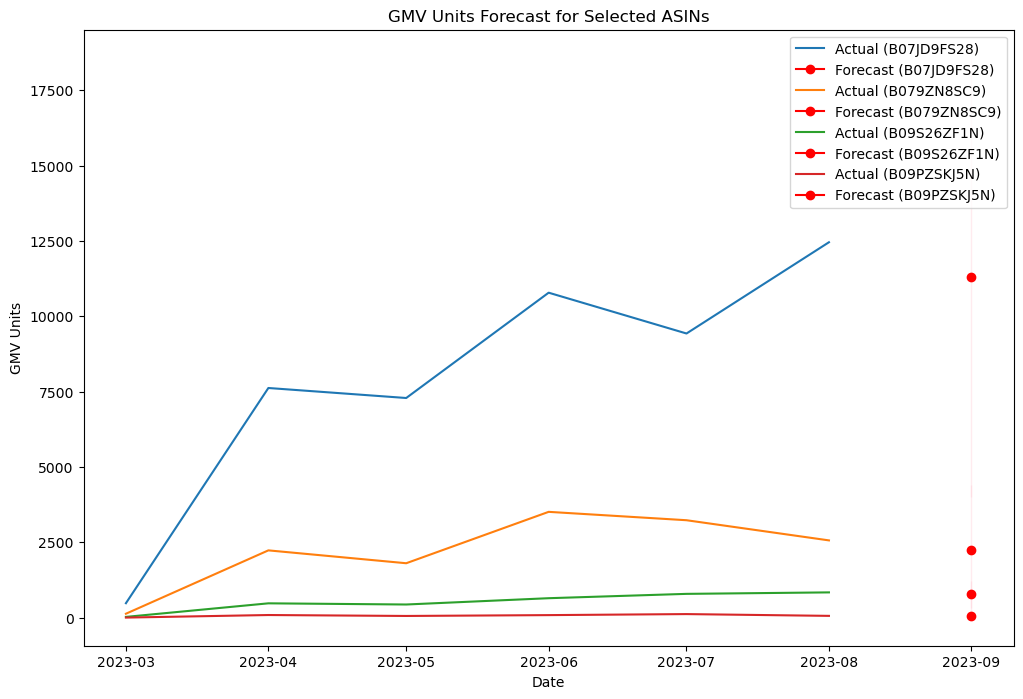

In [119]:
#version 2 : selected ASIN list

import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Ensure 'year_month' is in datetime format
df_batch1['year_month'] = pd.to_datetime(df_batch1['year_month'])

# Set the 'year_month' column as the index
df_batch1.set_index('year_month', inplace=True)

# List of ASINs to forecast and plot
selected_asins = ['B07JD9FS28', 'B079ZN8SC9', 'B09S26ZF1N', 'B09PZSKJ5N']  # Replace with actual ASINs

# Initialize a dictionary to store the forecast results
forecast_results = {}

# Loop through each ASIN and perform forecasting
for asin in selected_asins:
    # Filter the DataFrame for the current ASIN
    df_asin = df_batch1[df_batch1['asin'] == asin]

    # Build the Auto ARIMA model
    model = auto_arima(df_asin['gmv_units'], 
                       seasonal=False, 
                       trace=True, 
                       suppress_warnings=True)

    # Forecast the next month
    forecast, conf_int = model.predict(n_periods=1, return_conf_int=True)

    # Store the forecast results in the dictionary
    forecast_results[asin] = {
        'forecast': forecast[0],
        'lower_conf_int': conf_int[0, 0],
        'upper_conf_int': conf_int[0, 1]
    }

# Create a DataFrame to store all forecast results
df_forecasts = pd.DataFrame.from_dict(forecast_results, orient='index')
df_forecasts.index.name = 'ASIN'
df_forecasts.reset_index(inplace=True)
df_forecasts['forecast_date'] = pd.to_datetime('2023-09-01')  # Example future date for forecasts

# Save the forecast results to a CSV file
df_forecasts.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/forecast_results.csv', index=False)

# Print part of the result
print(df_forecasts.head())

# Plot the results for each selected ASIN
plt.figure(figsize=(12, 8))

for asin in selected_asins:
    df_asin = df_batch1[df_batch1['asin'] == asin]
    forecast_value = forecast_results[asin]['forecast']
    lower_conf_int = forecast_results[asin]['lower_conf_int']
    upper_conf_int = forecast_results[asin]['upper_conf_int']

    # Plot actual GMV units
    plt.plot(df_asin.index, df_asin['gmv_units'], label=f'Actual ({asin})')

    # Plot forecasted GMV units
    next_month = pd.to_datetime('2023-09-01')
    plt.plot([next_month], [forecast_value], label=f'Forecast ({asin})', marker='o', color='red')

    # Plot confidence interval
    plt.fill_between([next_month], 
                     [lower_conf_int], 
                     [upper_conf_int], 
                     color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('GMV Units')
plt.title('GMV Units Forecast for Selected ASINs')
plt.legend()
plt.show()


In [115]:
#Creatinf df to check Acurracy: 
# mapping actual values


# Filter df_monthly to include only the selected ASINs and the year_month of '2023-09-01'
selected_asins = ['B07JD9FS28', 'B079ZN8SC9', 'B09S26ZF1N', 'B09PZSKJ5N']
selected_date = pd.to_datetime('2023-09-01')

df_actuals = df_monthly[(df_monthly['asin'].isin(selected_asins)) & 
                        (df_monthly['year_month'] == selected_date)][['asin', 'gmv_units']]

# Rename the 'gmv_units' column to 'actual'
df_actuals.rename(columns={'gmv_units': 'actual', 'asin': 'ASIN'}, inplace=True)

# Merge the actuals with the df_forecasts DataFrame on 'asin'
df_forecasts_with_actuals = pd.merge(df_forecasts, df_actuals, on='ASIN', how='left')

# Display the result
print(df_forecasts_with_actuals)


         ASIN      forecast  lower_conf_int  upper_conf_int forecast_date  \
0  B07JD9FS28  11287.810219     3998.273227    18577.347210    2023-09-01   
1  B079ZN8SC9   2246.333333       78.156106     4414.510560    2023-09-01   
2  B09S26ZF1N    775.064258      327.861936     1222.266579    2023-09-01   
3  B09PZSKJ5N     68.666667       -1.534222      138.867556    2023-09-01   

   actual  
0    6578  
1    1399  
2     485  
3      63  


C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25160\2534107601.py:10: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  (df_monthly['year_month'] == selected_date)][['asin', 'gmv_units']]


In [106]:
print(df_month_sorted.columns)


Index(['velocity_bucket',            'asin',        2023-03-01,
              2023-04-01,        2023-05-01,        2023-06-01,
              2023-07-01,        2023-08-01,        2023-09-01,
              2023-10-01,        2023-11-01,        2023-12-01,
              2024-01-01,        2024-02-01,        2024-03-01,
              2024-04-01,        2024-05-01,        2024-06-01,
              2024-07-01],
      dtype='object')


In [116]:
#Accuracy Metrics for Time Series Forecast

import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)                             # ME
    mae = np.mean(np.abs(forecast - actual))                    # MAE
    mpe = np.mean((forecast - actual) / actual)                 # MPE
    rmse = np.mean((forecast - actual) ** 2) ** 0.5             # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]                  # corr
    mins = np.amin(np.vstack([forecast, actual]), axis=0)
    maxs = np.amax(np.vstack([forecast, actual]), axis=0)
    minmax = 1 - np.mean(mins / maxs)                           # minmax
    acf1 = acf(forecast - actual, fft=False)[1]                 # ACF1
    return {'mape': mape, 'me': me, 'mae': mae, 
            'mpe': mpe, 'rmse': rmse, 'acf1': acf1, 
            'corr': corr, 'minmax': minmax}

# Assuming df_forecasts_with_actuals is your DataFrame
fc = df_forecasts_with_actuals['forecast'].values
actual = df_forecasts_with_actuals['actual'].values

accuracy_metrics = forecast_accuracy(fc, actual)

# Display the accuracy metrics
print(accuracy_metrics)





{'mape': 0.502420674488742, 'me': 1463.2186191023402, 'mae': 1463.2186191023402, 'mpe': 0.502420674488742, 'rmse': 2397.1053094742892, 'acf1': 0.03002228281198419, 'corr': 0.9999395037650867, 'minmax': 0.31280611775789036}


C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25160\1229057974.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch1['year_month'] = pd.to_datetime(df_batch1['year_month'])
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,0)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **f

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,0)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\t

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,0)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", l

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmd

Error fitting model for ASIN B0C6Y478R5: too many indices for array: array is 0-dimensional, but 1 were indexed
Forecasts for all ASINs:
           asin year_month  forecast_gmv_units  lower_conf_int  upper_conf_int
0    B00PMR3QF2 2023-09-01         8725.833333     1524.903478    15926.763188
1    B00PV15BPW 2023-09-01         9271.728315     2741.910986    15801.545643
2    B00Q96XGUU 2023-09-01          134.000000     -116.482068      384.482068
3    B00QR6SS6O 2023-09-01         3303.500000      458.989936     6148.010064
4    B00QR7FTLU 2023-09-01          232.000000      -17.416487      481.416487
..          ...        ...                 ...             ...             ...
196  B0C658PXB1 2023-09-01            0.000000       -0.000020        0.000020
197  B0C65CP9PP 2023-09-01            0.000000     -560.549700      560.549700
198  B0C65CVJQG 2023-09-01            0.000000    -1728.688234     1728.688234
199  B0C6XVFJPZ 2023-09-01            0.000000     -597.789015      597.7

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


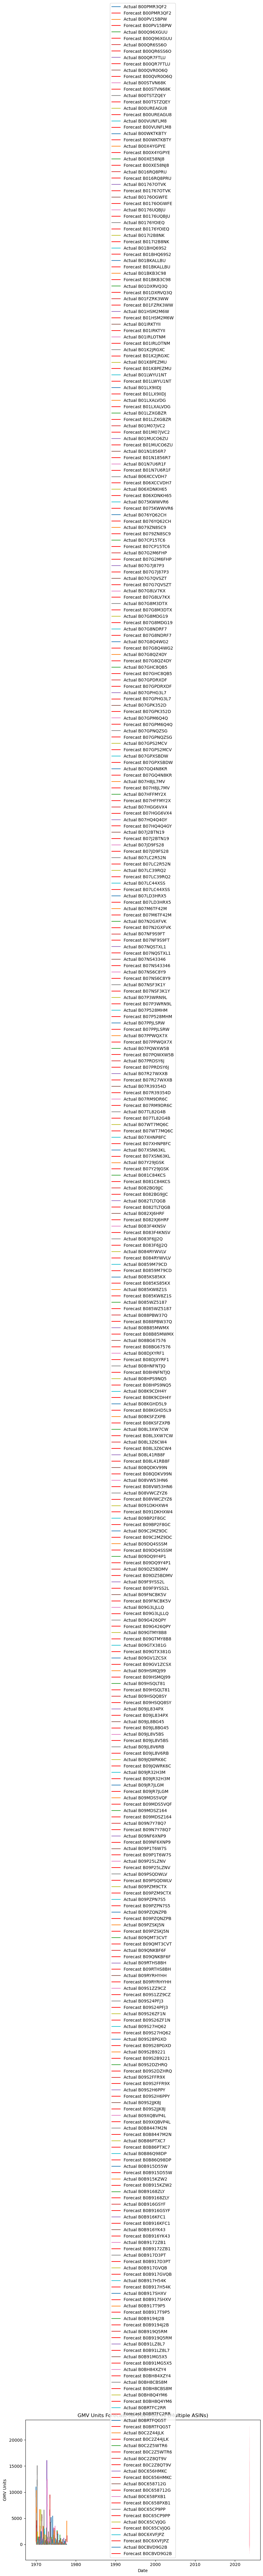

In [79]:
#version 3
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Ensure 'year_month' is in datetime format
df_batch1['year_month'] = pd.to_datetime(df_batch1['year_month'])

# Initialize a list to store the forecast results for all ASINs
all_forecasts = []

# Loop through each unique ASIN
for asin in df_batch1['asin'].unique():
    df_asin = df_batch1[df_batch1['asin'] == asin].copy()
    
    if df_asin.empty:
        print(f"Warning: No data for ASIN {asin}. Skipping...")
        continue
    
    # Set the 'year_month' column as the index
    df_asin.set_index('year_month', inplace=True)
    
    # Check data quality
    if df_asin['gmv_units'].isna().sum() > 0:
        print(f"Warning: Missing values found for ASIN {asin}. Handling missing values...")
        df_asin['gmv_units'].fillna(method='ffill', inplace=True)  # Forward fill for simplicity
    
    # Build the Auto ARIMA model
    try:
        model = auto_arima(df_asin['gmv_units'], 
                           seasonal=False, 
                           trace=False, 
                           suppress_warnings=True)
        
        # Forecast the next month (2023-09-01)
        forecast, conf_int = model.predict(n_periods=1, return_conf_int=True)
        
        # Create a DataFrame for the forecast
        next_month = pd.to_datetime('2023-09-01')
        forecast_df = pd.DataFrame({
            'asin': [asin],
            'year_month': [next_month],
            'forecast_gmv_units': forecast,
            'lower_conf_int': conf_int[:, 0],
            'upper_conf_int': conf_int[:, 1]
        })
        
        # Append the forecast to the list of all forecasts
        all_forecasts.append(forecast_df)
    
    except Exception as e:
        print(f"Error fitting model for ASIN {asin}: {e}")

# Combine all forecasts into a single DataFrame
df_forecasts = pd.concat(all_forecasts, ignore_index=True)

print("Forecasts for all ASINs:")
print(df_forecasts)

# Save the forecast results to a CSV file
df_forecasts.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/forecast_results.csv', index=False)

# Optional: Plot the results for one or more ASINs
plt.figure(figsize=(10, 6))

for asin in df_forecasts['asin'].unique():
    df_asin = df_batch1[df_batch1['asin'] == asin]
    df_asin_forecast = df_forecasts[df_forecasts['asin'] == asin]
    
    plt.plot(df_asin.index, df_asin['gmv_units'], label=f'Actual {asin}')
    plt.plot(df_asin_forecast['year_month'], df_asin_forecast['forecast_gmv_units'], label=f'Forecast {asin}', color='red')
    plt.fill_between(df_asin_forecast['year_month'], 
                     df_asin_forecast['lower_conf_int'], 
                     df_asin_forecast['upper_conf_int'], 
                     color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('GMV Units')
plt.title('GMV Units Forecast for 2023-09-01 (Multiple ASINs)')
plt.legend()
plt.show()


In [85]:
# Version-1

import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Ensure 'year_month' is in datetime format
df_batch1['year_month'] = pd.to_datetime(df_batch1['year_month'])

# Filter the data for the selected year_month values
selected_dates = ['2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01']
selected_dates = [pd.to_datetime(date) for date in selected_dates]

df_selected = df_batch1[df_batch1['year_month'].isin(selected_dates)].sort_values('year_month')

# Set the 'year_month' column as the index
df_selected.set_index('year_month', inplace=True)

# Build the Auto ARIMA model
model = auto_arima(df_selected['gmv_units'], 
                   seasonal=False, 
                   trace=True, 
                   suppress_warnings=True)

# Forecast the next month (2023-09-01)
forecast, conf_int = model.predict(n_periods=1, return_conf_int=True)

# Create a DataFrame for the forecast
next_month = pd.to_datetime('2023-09-01')
forecast_df = pd.DataFrame({
    'year_month': [next_month],
    'forecast_gmv_units': forecast,
    'lower_conf_int': conf_int[:, 0],
    'upper_conf_int': conf_int[:, 1]
})

# print("Forecast for 2023-09-01:")
# print(forecast_df)

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(df_selected.index, df_selected['gmv_units'], label='Actual')
# plt.plot(forecast_df['year_month'], forecast_df['forecast_gmv_units'], label='Forecast', color='red')
# plt.fill_between(forecast_df['year_month'], 
#                  forecast_df['lower_conf_int'], 
#                  forecast_df['upper_conf_int'], 
#                  color='pink', alpha=0.3)
# plt.xlabel('Date')
# plt.ylabel('GMV Units')
# plt.title('GMV Units Forecast for 2023-09-01')
# plt.legend()
# plt.show()


C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25160\2533260709.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch1['year_month'] = pd.to_datetime(df_batch1['year_month'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20027.552, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20755.557, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20463.818, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20753.558, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20026.177, Time=0.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=20025.648, Time=0.40 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=20027.141, Time=0.75 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20025.661, Time=0.46 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=20027.631, Time=0.89 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=20024.418, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=20022.626, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=20024.428, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20461.818, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]  

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# Plot the results for each selected ASIN

# List of ASINs to forecast and plot
selected_asins = ['B07JD9FS28', 'B079ZN8SC9', 'B09S26ZF1N', 'B09PZSKJ5N']

plt.figure(figsize=(12, 8))

for asin in selected_asins:
    df_asin = df_batch1[df_batch1['asin'] == asin]
    forecast_value = forecast_results[asin]['forecast']
    lower_conf_int = forecast_results[asin]['lower_conf_int']
    upper_conf_int = forecast_results[asin]['upper_conf_int']

    # Plot actual GMV units
    plt.plot(df_asin.index, df_asin['gmv_units'], label=f'Actual ({asin})')

    # Plot forecasted GMV units
    next_month = pd.to_datetime('2023-09-01')
    plt.plot([next_month], [forecast_value], label=f'Forecast ({asin})', marker='o', color='red')

    # Plot confidence interval
    plt.fill_between([next_month], 
                     [lower_conf_int], 
                     [upper_conf_int], 
                     color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('GMV Units')
plt.title('GMV Units Forecast for Selected ASINs')
plt.legend()
plt.show()